In [1]:
# !pip install datasets
# !pip install transformers[torch]
# !pip install accelerate -U

In [1]:
import torch
import torch.nn.functional as F
from src.utils import *
from src.models.models import Model_Phrase_Concatenation, Model_Phrase_Extraction, Model_concat_nopooling
from src.models.baseline import Baseline
from datasets import concatenate_datasets
from sklearn.utils.class_weight import compute_class_weight
from transformers import DefaultDataCollator, AutoTokenizer, TrainingArguments, Trainer

In [2]:
RANDOM_SEED = 42
set_seeds(RANDOM_SEED)

print(torch.__version__)
print(torch.cuda.is_available())

2.2.2+cu121
True


In [3]:
url = "https://drive.google.com/uc?export=download&id=1wVNU2XvvhqjaGXZM-JLJwOt97gt4g9j2"
dataset_name = "MELD_train_efr.json"

df_manager = DataframeManager(url, dataset_name)

df = df_manager.produce_df()
df

Current work directory: c:\Users\cacio\Desktop\jacopo\scuola\UNIBO MASTER\NATURAL LANGUAGE PROCESSING\project\ediref


,episode,emotions,utterances,triggers,emotions_id
0,utterance_0,"[neutral, neutral, neutral, neutral, surprise]",[also I was the point person on my company's t...,"[0, 0, 0, 1, 0]","[4, 4, 4, 4, 3]"
1,utterance_1,"[neutral, neutral, neutral, neutral, surprise,...",[also I was the point person on my company's t...,"[0, 0, 0, 0, 0, 1, 0]","[4, 4, 4, 4, 3, 4, 4]"
2,utterance_2,"[neutral, neutral, neutral, neutral, surprise,...",[also I was the point person on my company's t...,"[0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0]","[4, 4, 4, 4, 3, 4, 4, 4, 4, 4, 1]"
3,utterance_3,"[neutral, neutral, neutral, neutral, surprise,...",[also I was the point person on my company's t...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0]","[4, 4, 4, 4, 3, 4, 4, 4, 4, 4, 1, 4, 3]"
4,utterance_4,"[surprise, sadness, surprise, fear]",[But then who? The waitress I went out with la...,"[0, 0, 1, 0]","[3, 0, 3, 1]"
...,...,...,...,...,...
3995,utterance_3995,"[neutral, joy, neutral, neutral, surprise, dis...","[Hey., Hey!, So how was Joan?, I broke up with...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]","[4, 6, 4, 4, 3, 2, 4, 2, 3, 4, 4, 2]"
3996,utterance_3996,"[neutral, joy, neutral, neutral, surprise, dis...","[Hey., Hey!, So how was Joan?, I broke up with...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]","[4, 6, 4, 4, 3, 2, 4, 2, 3, 4, 4, 2, 2, 4]"
3997,utterance_3997,"[neutral, joy, neutral, neutral, surprise, dis...","[Hey., Hey!, So how was Joan?, I broke up with...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0]","[4, 6, 4, 4, 3, 2, 4, 2, 3, 4, 4, 2, 2, 4, 4]"
3998,utterance_3998,"[neutral, joy, neutral, neutral, surprise, dis...","[Hey., Hey!, So how was Joan?, I broke up with...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0]","[4, 6, 4, 4, 3, 2, 4, 2, 3, 4, 4, 2, 2, 4, 4, 3]"


In [4]:
train_df, val_df, test_df = df_manager.split_df(RANDOM_SEED)
print(train_df.shape)
print(val_df.shape)
print(test_df.shape)

(3200, 5)
(400, 5)
(400, 5)


c:\Users\cacio\Desktop\jacopo\scuola\UNIBO MASTER\NATURAL LANGUAGE PROCESSING\project\ediref\ediref\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


c:\Users\cacio\Desktop\jacopo\scuola\UNIBO MASTER\NATURAL LANGUAGE PROCESSING\project\ediref\src\utils.py:276: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  return pd.DataFrame({key: pd.value_counts(values)
c:\Users\cacio\Desktop\jacopo\scuola\UNIBO MASTER\NATURAL LANGUAGE PROCESSING\project\ediref\src\utils.py:276: FutureWarning: value_counts with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  return pd.DataFrame({key: pd.value_counts(values)
c:\Users\cacio\Desktop\jacopo\scuola\UNIBO MASTER\NATURAL LANGUAGE PROCESSING\project\ediref\src\utils.py:276: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  return pd.DataFrame({key: pd.value_counts(values)
c:\Users\cacio\Desktop\jacopo\scuola\UNIBO MASTER\NATURAL LANGUAGE PROCESSING\project\edir

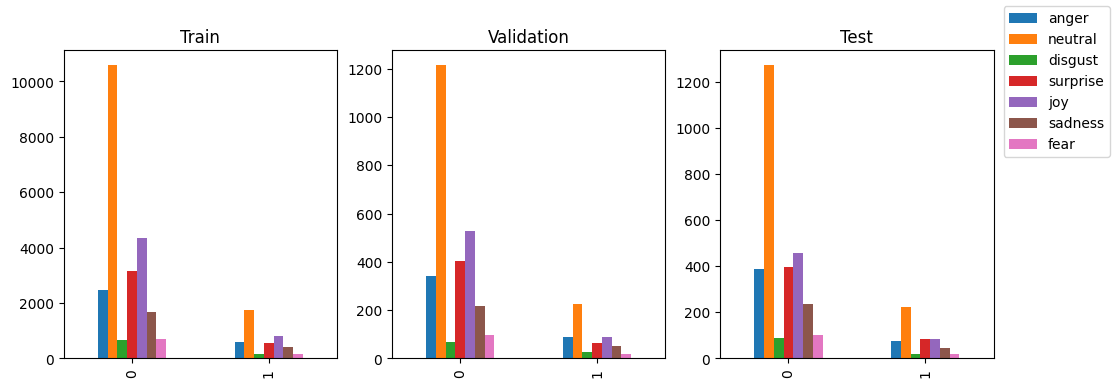

In [5]:
df_manager.plot_emotion_distribution(train_df, val_df, test_df)

In [6]:
#ELECTRA TOKENIZER

model_card = 'google/electra-base-discriminator'
tokenizer = AutoTokenizer.from_pretrained(model_card)

model_dir =  "./model_dir/"+model_card.split("/")[-1]+"/"
data_collator = DefaultDataCollator()

In [7]:
#BERT TOKENIZER

model_card = 'bert-base-uncased'
tokenizer = AutoTokenizer.from_pretrained(model_card)

model_dir = "./model_dir/"+model_card+"/"
data_collator = DefaultDataCollator()

In [7]:
train_data_tokenized, val_data_tokenized, test_data_tokenized = df_manager.produce_dataset(tokenizer, RANDOM_SEED)

c:\Users\cacio\Desktop\jacopo\scuola\UNIBO MASTER\NATURAL LANGUAGE PROCESSING\project\ediref\ediref\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


In [8]:
print(len(train_data_tokenized))
print(len(val_data_tokenized))
print(len(test_data_tokenized))

28062
3437
3501


Models

In [9]:
test_data_tokenized

Dataset({
    features: ['episode', 'emotions_id_one_hot_encoding', 'emotions_id', 'triggers', 'dialogue_ids', 'dialogue_mask', 'dialogue_index', 'dialogue_text', 'utterance_ids', 'utterance_mask', 'utterance_index'],
    num_rows: 3501
})

In [15]:
#ELECTRA CLASS POS WEIGHT
def init_pos_weight(data, labels_column, class_weights=True, factor=1):
    #y = data[labels_column].numpy()
    y = data[labels_column]
    if class_weights:
        return torch.tensor(compute_class_weight(class_weight="balanced", classes=np.unique(y), y=y)).to("cuda")
    else:
        return torch.tensor(compute_class_weight(class_weight=None, classes=np.unique(y), y=y)).to("cuda")

In [13]:
#BERT CLASS POS WEIGHT
def init_pos_weight(data, labels, class_weights=True, factor=1):
    if class_weights:
        pos_weight = list()
        emotions_counts = {label:0 for label in df_manager.unique_emotions}
        for sentence_emotions in data[df_manager.column_emotions_id]:
            for emotion in sentence_emotions:
                emotions_counts[emotion] = emotions_counts[emotion] + 1
        sum_of_all_emotions = sum(emotions_counts.values())
        for label in labels:
            w = (sum_of_all_emotions-emotions_counts[label])/emotions_counts[label]   # num_neg/num_pos for each class as specified in the documentation for BCEWithLogitsLoss
            if w > 1:                       # increase recall of minority classes
                w*=factor                   # factor to magnify the weight (not standard)
                pos_weight.append(w)
            else:
                pos_weight.append(1)        # non minority classes are not influenced (pos_weight = 1)
        return torch.tensor(pos_weight).to("cuda")
    else:
        return torch.ones([len(labels)]).to("cuda")

In [16]:
#ELECTRA CLASS TRAINER

class MultiLabelTrainer(Trainer):
    def __init__(self, pos_weight=None, **kwargs):
        self.emotions_pos_weight, self.triggers_pos_weight = pos_weight
        super().__init__(**kwargs)

    def compute_loss(self, model, inputs, return_outputs=False):
        emotions_true = inputs["emotions_id_one_hot_encoding"].to("cuda")
        triggers_true = inputs["triggers"].unsqueeze(1).float().to("cuda")

        result = model(**inputs)
        
        emotion_logits = result['emotion_logits'].to("cuda")
        trigger_logits = result['trigger_logits'].to("cuda")
        
        loss_fct_emotions = torch.nn.CrossEntropyLoss(weight=self.emotions_pos_weight).to("cuda")        
        loss_fct_triggers = torch.nn.BCEWithLogitsLoss(pos_weight=self.triggers_pos_weight[1]).to("cuda")
        
        loss_emotions = loss_fct_emotions(emotion_logits, emotions_true.float())
        loss_triggers = loss_fct_triggers(trigger_logits, triggers_true)


        loss_emotions_wt = 0.5
        loss_triggers_wt = 0.5

        loss = loss_emotions_wt*loss_emotions + loss_triggers_wt*loss_triggers
        return (loss, {'emotion_logits': emotion_logits, 'trigger_logits': trigger_logits}) if return_outputs else loss

def get_trainer(model, train, val, model_dir, class_weights=True, batch_size=1, epochs=20):
    training_args = TrainingArguments(
        output_dir=model_dir,
        learning_rate=2e-5,
        per_device_train_batch_size=batch_size,
        per_device_eval_batch_size=batch_size,
        num_train_epochs=epochs,
        weight_decay=0.01,
        evaluation_strategy="epoch",
        save_strategy="epoch",
        save_total_limit=1,
        lr_scheduler_type="cosine",
        metric_for_best_model='u_avg_f1',
        report_to='none',
        label_names=["emotions_id", "triggers", "dialogue_index"],
    )

    full_dataset = concatenate_datasets([train_data_tokenized, val_data_tokenized, test_data_tokenized])
    pos_weight = (init_pos_weight(full_dataset, df_manager.column_emotions_id, class_weights), init_pos_weight(full_dataset, df_manager.column_triggers, class_weights))

    trainer = MultiLabelTrainer(
        pos_weight=pos_weight,
        model=model,
        args=training_args,
        train_dataset=train,
        eval_dataset=val,
        tokenizer=tokenizer,
        data_collator=data_collator,
        compute_metrics=lambda pred: compute_metrics(pred, len(df_manager.emotion2id.keys()))
    )

    return trainer

In [15]:
#BERT CLASS TRAINER

class MultiLabelTrainer(Trainer):
    def __init__(self, pos_weight, **kwargs):
        self.pos_weight = pos_weight
        super().__init__(**kwargs)

    def compute_loss(self, model, inputs, return_outputs=False):
        emotions_true = inputs["emotions_id_one_hot_encoding"].to("cuda")
        triggers_true = inputs["triggers"].unsqueeze(1).float().to("cuda")

        result = model(**inputs)
        
        emotion_logits = result['emotion_logits'].to("cuda")
        trigger_logits = result['trigger_logits'].to("cuda")
        
        loss_fct_emotions = torch.nn.CrossEntropyLoss().to("cuda")        
        loss_fct_triggers = torch.nn.BCEWithLogitsLoss().to("cuda")

        loss_emotions = loss_fct_emotions(emotion_logits, emotions_true.float())
        loss_triggers = loss_fct_triggers(trigger_logits, triggers_true)

        loss = loss_emotions + loss_triggers
        return (loss, {'emotion_logits': emotion_logits, 'trigger_logits': trigger_logits}) if return_outputs else loss

def get_trainer(model, train, val, model_dir, class_weights=True, batch_size=1, epochs=20):
    training_args = TrainingArguments(
        output_dir=model_dir,
        learning_rate=2e-5,
        per_device_train_batch_size=batch_size,
        per_device_eval_batch_size=batch_size,
        num_train_epochs=epochs,
        weight_decay=0.01,
        evaluation_strategy="steps",
        save_strategy="steps",
        lr_scheduler_type="cosine",
        save_total_limit = 1,
        load_best_model_at_end=True,
        metric_for_best_model='eval_loss',
        report_to='none',
        label_names=["emotions_id", "triggers", "dialogue_index", "emotions_id_one_hot_encoding"],
    )
    pos_weight = init_pos_weight(concatenate_datasets([train_data_tokenized, val_data_tokenized, test_data_tokenized]), df_manager.emotion2id.keys(), False)
    trainer = MultiLabelTrainer(
        pos_weight=pos_weight,
        model=model,
        args=training_args,
        train_dataset=train,
        eval_dataset=val,
        tokenizer=tokenizer,
        data_collator=data_collator,
        compute_metrics=lambda pred: compute_metrics(pred, len(df_manager.emotion2id.keys())),
    )

    return trainer

In [12]:
#intialize class for error analysis (SELECT FIRST WHICH DATASET TO USE)
from src import error
import importlib
importlib.reload(error)
test_report = error.ErrorAnalysis(test_data_tokenized)
val_report = error.ErrorAnalysis(val_data_tokenized)

### BERT LOAD PREDICTIONS

In [76]:
import os
model_dir = "./already_trained_models/trained_models/bert_concat"
#set_seeds(49)
base_model = Model_concat_nopooling(len(df_manager.unique_emotions), tokenizer.sep_token_id)
model_path = os.path.join(model_dir, "bert_concat_nopooling_49.pth")
base_model.load_state_dict(torch.load(model_path))

trainer = get_trainer(base_model, train_data_tokenized, val_data_tokenized, './trained_models', class_weights=True, batch_size=4, epochs=5)
prediction = trainer.predict(val_data_tokenized)
prediction

c:\Users\cacio\Desktop\jacopo\scuola\UNIBO MASTER\NATURAL LANGUAGE PROCESSING\project\ediref\ediref\Lib\site-packages\accelerate\accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


  0%|          | 0/860 [00:00<?, ?it/s]

PredictionOutput(predictions=(array([[-0.34950823, -1.8695816 , -1.9935911 , ..., -0.18335019,
         0.25831404, -0.1901654 ],
       [-1.4172022 , -1.8015509 , -0.44551998, ...,  5.6988673 ,
        -0.06012411, -1.6183275 ],
       [-1.4675945 , -1.6065032 , -1.9891231 , ...,  1.507411  ,
        -0.3905949 , -1.3454388 ],
       ...,
       [ 0.11573264, -1.4254138 , -2.6632204 , ...,  6.4625273 ,
        -0.6698389 , -0.22880372],
       [-0.6532373 , -1.4303167 , -2.162873  , ...,  6.8264923 ,
        -1.0507269 , -0.53007716],
       [-0.98327625, -3.7471771 , -2.0632226 , ..., -0.6566795 ,
         0.09050234,  1.1393502 ]], dtype=float32), array([[-3.022243 ],
       [-1.2566403],
       [-2.2619827],
       ...,
       [-3.7232473],
       [-3.178554 ],
       [-2.9150305]], dtype=float32)), label_ids=(array([3, 4, 6, ..., 4, 4, 3], dtype=int64), array([0, 1, 0, ..., 0, 0, 0], dtype=int64), array([  0,   0,   0, ..., 399, 399, 399], dtype=int64), array([[0, 0, 0, ..., 0, 0,

In [ ]:
#Table of bad vs goods
#BERT CONCAT 49 --------------------> GOOD
#BERT CONCAT NOOPOLING 49 --------------------> GOOD
#BERT EXTRACTION 111 --------------------> GOOD
#BERT EXTRACTION FREEZE 49 --------------------> GOOD
#BERT EXTRACTION FREEZE 51 --------------------> GOOD
#BERT EXTRACTION FREEZE 77 --------------------> GOOD
#BERT EXTRACTION FREEZE 666 --------------------> GOOD
#ELECTRA EXTRACTION 49 --------------------> 
#ELECTRA EXTRACTION 51 --------------------> 
#ELECTRA EXTRACTION 77 --------------------> 
#ELECTRA EXTRACTION 111 --------------------> 
#ELECTRA EXTRACTION 666 --------------------> 

In [19]:
import os
#!Note at evaluation freeze and unfreeze are the same
#berts extraction
model_dir = "./already_trained_models/trained_models/bert_extraction/"
model_filenames = [name for name in os.listdir(model_dir)]
models = [{"path":os.path.join(model_dir,name), "name":name[:-4], "dir":model_dir, "t": "extraction"} for name in model_filenames]

#bert concat
model_dir = "./already_trained_models/trained_models/bert_concat/"
model_filenames = [name for name in os.listdir(model_dir)]
models = models + [{"path":os.path.join(model_dir,name), "name":name[:-4], "dir":model_dir, "t": "concat"} for name in model_filenames]

#bert no pooling
model_dir = "./already_trained_models/trained_models/bert_concat_nopooling/"
model_filenames = [name for name in os.listdir(model_dir)]
models = models + [{"path":os.path.join(model_dir,name), "name":name[:-4], "dir":model_dir, "t": "nopooling"} for name in model_filenames]

models

[{'path': './already_trained_models/trained_models/bert_extraction/bert_extraction_111.pth',
  'name': 'bert_extraction_111',
  'dir': './already_trained_models/trained_models/bert_extraction/',
  't': 'extraction'},
 {'path': './already_trained_models/trained_models/bert_extraction/bert_extraction_49.pth',
  'name': 'bert_extraction_49',
  'dir': './already_trained_models/trained_models/bert_extraction/',
  't': 'extraction'},
 {'path': './already_trained_models/trained_models/bert_extraction/bert_extraction_51.pth',
  'name': 'bert_extraction_51',
  'dir': './already_trained_models/trained_models/bert_extraction/',
  't': 'extraction'},
 {'path': './already_trained_models/trained_models/bert_extraction/bert_extraction_666.pth',
  'name': 'bert_extraction_666',
  'dir': './already_trained_models/trained_models/bert_extraction/',
  't': 'extraction'},
 {'path': './already_trained_models/trained_models/bert_extraction/bert_extraction_77.pth',
  'name': 'bert_extraction_77',
  'dir': './

In [24]:
#LOOP FOR UPLOADING PREDICTIONS IN THE REPORT

for model_setting in models:
        model_name = model_setting['name']
        model_path = model_setting['path']
        model_dir = model_setting['dir']
        t = model_setting['t']

        if t == 'extraction':
                base_model = Model_Phrase_Extraction(len(df_manager.unique_emotions), tokenizer.sep_token_id)
        elif t == 'concat':
                base_model = Model_Phrase_Concatenation(len(df_manager.unique_emotions), tokenizer.sep_token_id)
        elif t == 'nopooling':
                base_model = Model_concat_nopooling(len(df_manager.unique_emotions), tokenizer.sep_token_id)
        else:
                raise Exception("Type of model not found")

        base_model.load_state_dict(torch.load(model_path))

        trainer = get_trainer(base_model, train_data_tokenized, val_data_tokenized, './trained_models', class_weights=True, batch_size=4, epochs=5)

        # add predictions to the report
        print(val_report.add_model(trainer, val_data_tokenized, model_name))
        print(test_report.add_model(trainer, test_data_tokenized, model_name))

c:\Users\cacio\Desktop\jacopo\scuola\UNIBO MASTER\NATURAL LANGUAGE PROCESSING\project\ediref\ediref\Lib\site-packages\accelerate\accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


  0%|          | 0/860 [00:00<?, ?it/s]

torch.Size([3437, 7]) torch.Size([3437, 1])
Successfullty added model!(Successfullty added predictions for model bert_extraction_111!, Successfullty added predictions for model bert_extraction_111_t!)


  0%|          | 0/876 [00:00<?, ?it/s]

torch.Size([3501, 7]) torch.Size([3501, 1])
Successfullty added model!(Successfullty added predictions for model bert_extraction_111!, Successfullty added predictions for model bert_extraction_111_t!)


c:\Users\cacio\Desktop\jacopo\scuola\UNIBO MASTER\NATURAL LANGUAGE PROCESSING\project\ediref\ediref\Lib\site-packages\accelerate\accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


  0%|          | 0/860 [00:00<?, ?it/s]

torch.Size([3437, 7]) torch.Size([3437, 1])
Successfullty added model!(Successfullty added predictions for model bert_extraction_49!, Successfullty added predictions for model bert_extraction_49_t!)


  0%|          | 0/876 [00:00<?, ?it/s]

torch.Size([3501, 7]) torch.Size([3501, 1])
Successfullty added model!(Successfullty added predictions for model bert_extraction_49!, Successfullty added predictions for model bert_extraction_49_t!)


c:\Users\cacio\Desktop\jacopo\scuola\UNIBO MASTER\NATURAL LANGUAGE PROCESSING\project\ediref\ediref\Lib\site-packages\accelerate\accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


  0%|          | 0/860 [00:00<?, ?it/s]

torch.Size([3437, 7]) torch.Size([3437, 1])
Successfullty added model!(Successfullty added predictions for model bert_extraction_51!, Successfullty added predictions for model bert_extraction_51_t!)


  0%|          | 0/876 [00:00<?, ?it/s]

torch.Size([3501, 7]) torch.Size([3501, 1])
Successfullty added model!(Successfullty added predictions for model bert_extraction_51!, Successfullty added predictions for model bert_extraction_51_t!)


c:\Users\cacio\Desktop\jacopo\scuola\UNIBO MASTER\NATURAL LANGUAGE PROCESSING\project\ediref\ediref\Lib\site-packages\accelerate\accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


  0%|          | 0/860 [00:00<?, ?it/s]

torch.Size([3437, 7]) torch.Size([3437, 1])
Successfullty added model!(Successfullty added predictions for model bert_extraction_666!, Successfullty added predictions for model bert_extraction_666_t!)


  0%|          | 0/876 [00:00<?, ?it/s]

torch.Size([3501, 7]) torch.Size([3501, 1])
Successfullty added model!(Successfullty added predictions for model bert_extraction_666!, Successfullty added predictions for model bert_extraction_666_t!)


c:\Users\cacio\Desktop\jacopo\scuola\UNIBO MASTER\NATURAL LANGUAGE PROCESSING\project\ediref\ediref\Lib\site-packages\accelerate\accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


  0%|          | 0/860 [00:00<?, ?it/s]

torch.Size([3437, 7]) torch.Size([3437, 1])
Successfullty added model!(Successfullty added predictions for model bert_extraction_77!, Successfullty added predictions for model bert_extraction_77_t!)


  0%|          | 0/876 [00:00<?, ?it/s]

torch.Size([3501, 7]) torch.Size([3501, 1])
Successfullty added model!(Successfullty added predictions for model bert_extraction_77!, Successfullty added predictions for model bert_extraction_77_t!)


c:\Users\cacio\Desktop\jacopo\scuola\UNIBO MASTER\NATURAL LANGUAGE PROCESSING\project\ediref\ediref\Lib\site-packages\accelerate\accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


  0%|          | 0/860 [00:00<?, ?it/s]

torch.Size([3437, 7]) torch.Size([3437, 1])
Successfullty added model!(Successfullty added predictions for model bert_extraction_freeze_111!, Successfullty added predictions for model bert_extraction_freeze_111_t!)


  0%|          | 0/876 [00:00<?, ?it/s]

torch.Size([3501, 7]) torch.Size([3501, 1])
Successfullty added model!(Successfullty added predictions for model bert_extraction_freeze_111!, Successfullty added predictions for model bert_extraction_freeze_111_t!)


c:\Users\cacio\Desktop\jacopo\scuola\UNIBO MASTER\NATURAL LANGUAGE PROCESSING\project\ediref\ediref\Lib\site-packages\accelerate\accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


  0%|          | 0/860 [00:00<?, ?it/s]

torch.Size([3437, 7]) torch.Size([3437, 1])
Successfullty added model!(Successfullty added predictions for model bert_extraction_freeze_49!, Successfullty added predictions for model bert_extraction_freeze_49_t!)


  0%|          | 0/876 [00:00<?, ?it/s]

torch.Size([3501, 7]) torch.Size([3501, 1])
Successfullty added model!(Successfullty added predictions for model bert_extraction_freeze_49!, Successfullty added predictions for model bert_extraction_freeze_49_t!)


c:\Users\cacio\Desktop\jacopo\scuola\UNIBO MASTER\NATURAL LANGUAGE PROCESSING\project\ediref\ediref\Lib\site-packages\accelerate\accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


  0%|          | 0/860 [00:00<?, ?it/s]

torch.Size([3437, 7]) torch.Size([3437, 1])
Successfullty added model!(Successfullty added predictions for model bert_extraction_freeze_51!, Successfullty added predictions for model bert_extraction_freeze_51_t!)


  0%|          | 0/876 [00:00<?, ?it/s]

torch.Size([3501, 7]) torch.Size([3501, 1])
Successfullty added model!(Successfullty added predictions for model bert_extraction_freeze_51!, Successfullty added predictions for model bert_extraction_freeze_51_t!)


c:\Users\cacio\Desktop\jacopo\scuola\UNIBO MASTER\NATURAL LANGUAGE PROCESSING\project\ediref\ediref\Lib\site-packages\accelerate\accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


  0%|          | 0/860 [00:00<?, ?it/s]

torch.Size([3437, 7]) torch.Size([3437, 1])
Successfullty added model!(Successfullty added predictions for model bert_extraction_freeze_666!, Successfullty added predictions for model bert_extraction_freeze_666_t!)


  0%|          | 0/876 [00:00<?, ?it/s]

torch.Size([3501, 7]) torch.Size([3501, 1])
Successfullty added model!(Successfullty added predictions for model bert_extraction_freeze_666!, Successfullty added predictions for model bert_extraction_freeze_666_t!)


c:\Users\cacio\Desktop\jacopo\scuola\UNIBO MASTER\NATURAL LANGUAGE PROCESSING\project\ediref\ediref\Lib\site-packages\accelerate\accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


  0%|          | 0/860 [00:00<?, ?it/s]

torch.Size([3437, 7]) torch.Size([3437, 1])
Successfullty added model!(Successfullty added predictions for model bert_extraction_freeze_77!, Successfullty added predictions for model bert_extraction_freeze_77_t!)


  0%|          | 0/876 [00:00<?, ?it/s]

torch.Size([3501, 7]) torch.Size([3501, 1])
Successfullty added model!(Successfullty added predictions for model bert_extraction_freeze_77!, Successfullty added predictions for model bert_extraction_freeze_77_t!)


c:\Users\cacio\Desktop\jacopo\scuola\UNIBO MASTER\NATURAL LANGUAGE PROCESSING\project\ediref\ediref\Lib\site-packages\accelerate\accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


  0%|          | 0/860 [00:00<?, ?it/s]

torch.Size([3437, 7]) torch.Size([3437, 1])
Successfullty added model!(Successfullty added predictions for model bert_concat_111!, Successfullty added predictions for model bert_concat_111_t!)


  0%|          | 0/876 [00:00<?, ?it/s]

torch.Size([3501, 7]) torch.Size([3501, 1])
Successfullty added model!(Successfullty added predictions for model bert_concat_111!, Successfullty added predictions for model bert_concat_111_t!)


c:\Users\cacio\Desktop\jacopo\scuola\UNIBO MASTER\NATURAL LANGUAGE PROCESSING\project\ediref\ediref\Lib\site-packages\accelerate\accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


  0%|          | 0/860 [00:00<?, ?it/s]

torch.Size([3437, 7]) torch.Size([3437, 1])
Successfullty added model!(Successfullty added predictions for model bert_concat_49!, Successfullty added predictions for model bert_concat_49_t!)


  0%|          | 0/876 [00:00<?, ?it/s]

torch.Size([3501, 7]) torch.Size([3501, 1])
Successfullty added model!(Successfullty added predictions for model bert_concat_49!, Successfullty added predictions for model bert_concat_49_t!)


c:\Users\cacio\Desktop\jacopo\scuola\UNIBO MASTER\NATURAL LANGUAGE PROCESSING\project\ediref\ediref\Lib\site-packages\accelerate\accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


  0%|          | 0/860 [00:00<?, ?it/s]

torch.Size([3437, 7]) torch.Size([3437, 1])
Successfullty added model!(Successfullty added predictions for model bert_concat_51!, Successfullty added predictions for model bert_concat_51_t!)


  0%|          | 0/876 [00:00<?, ?it/s]

torch.Size([3501, 7]) torch.Size([3501, 1])
Successfullty added model!(Successfullty added predictions for model bert_concat_51!, Successfullty added predictions for model bert_concat_51_t!)


c:\Users\cacio\Desktop\jacopo\scuola\UNIBO MASTER\NATURAL LANGUAGE PROCESSING\project\ediref\ediref\Lib\site-packages\accelerate\accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


  0%|          | 0/860 [00:00<?, ?it/s]

torch.Size([3437, 7]) torch.Size([3437, 1])
Successfullty added model!(Successfullty added predictions for model bert_concat_666!, Successfullty added predictions for model bert_concat_666_t!)


  0%|          | 0/876 [00:00<?, ?it/s]

torch.Size([3501, 7]) torch.Size([3501, 1])
Successfullty added model!(Successfullty added predictions for model bert_concat_666!, Successfullty added predictions for model bert_concat_666_t!)


c:\Users\cacio\Desktop\jacopo\scuola\UNIBO MASTER\NATURAL LANGUAGE PROCESSING\project\ediref\ediref\Lib\site-packages\accelerate\accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


  0%|          | 0/860 [00:00<?, ?it/s]

torch.Size([3437, 7]) torch.Size([3437, 1])
Successfullty added model!(Successfullty added predictions for model bert_concat_77!, Successfullty added predictions for model bert_concat_77_t!)


  0%|          | 0/876 [00:00<?, ?it/s]

torch.Size([3501, 7]) torch.Size([3501, 1])
Successfullty added model!(Successfullty added predictions for model bert_concat_77!, Successfullty added predictions for model bert_concat_77_t!)


c:\Users\cacio\Desktop\jacopo\scuola\UNIBO MASTER\NATURAL LANGUAGE PROCESSING\project\ediref\ediref\Lib\site-packages\accelerate\accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


  0%|          | 0/860 [00:00<?, ?it/s]

torch.Size([3437, 7]) torch.Size([3437, 1])
Successfullty added model!(Successfullty added predictions for model bert_concat_nopooling_111!, Successfullty added predictions for model bert_concat_nopooling_111_t!)


  0%|          | 0/876 [00:00<?, ?it/s]

torch.Size([3501, 7]) torch.Size([3501, 1])
Successfullty added model!(Successfullty added predictions for model bert_concat_nopooling_111!, Successfullty added predictions for model bert_concat_nopooling_111_t!)


c:\Users\cacio\Desktop\jacopo\scuola\UNIBO MASTER\NATURAL LANGUAGE PROCESSING\project\ediref\ediref\Lib\site-packages\accelerate\accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


  0%|          | 0/860 [00:00<?, ?it/s]

torch.Size([3437, 7]) torch.Size([3437, 1])
Successfullty added model!(Successfullty added predictions for model bert_concat_nopooling_49!, Successfullty added predictions for model bert_concat_nopooling_49_t!)


  0%|          | 0/876 [00:00<?, ?it/s]

torch.Size([3501, 7]) torch.Size([3501, 1])
Successfullty added model!(Successfullty added predictions for model bert_concat_nopooling_49!, Successfullty added predictions for model bert_concat_nopooling_49_t!)


c:\Users\cacio\Desktop\jacopo\scuola\UNIBO MASTER\NATURAL LANGUAGE PROCESSING\project\ediref\ediref\Lib\site-packages\accelerate\accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


  0%|          | 0/860 [00:00<?, ?it/s]

torch.Size([3437, 7]) torch.Size([3437, 1])
Successfullty added model!(Successfullty added predictions for model bert_concat_nopooling_51!, Successfullty added predictions for model bert_concat_nopooling_51_t!)


  0%|          | 0/876 [00:00<?, ?it/s]

torch.Size([3501, 7]) torch.Size([3501, 1])
Successfullty added model!(Successfullty added predictions for model bert_concat_nopooling_51!, Successfullty added predictions for model bert_concat_nopooling_51_t!)


c:\Users\cacio\Desktop\jacopo\scuola\UNIBO MASTER\NATURAL LANGUAGE PROCESSING\project\ediref\ediref\Lib\site-packages\accelerate\accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


  0%|          | 0/860 [00:00<?, ?it/s]

torch.Size([3437, 7]) torch.Size([3437, 1])
Successfullty added model!(Successfullty added predictions for model bert_concat_nopooling_666!, Successfullty added predictions for model bert_concat_nopooling_666_t!)


  0%|          | 0/876 [00:00<?, ?it/s]

torch.Size([3501, 7]) torch.Size([3501, 1])
Successfullty added model!(Successfullty added predictions for model bert_concat_nopooling_666!, Successfullty added predictions for model bert_concat_nopooling_666_t!)


c:\Users\cacio\Desktop\jacopo\scuola\UNIBO MASTER\NATURAL LANGUAGE PROCESSING\project\ediref\ediref\Lib\site-packages\accelerate\accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


  0%|          | 0/860 [00:00<?, ?it/s]

torch.Size([3437, 7]) torch.Size([3437, 1])
Successfullty added model!(Successfullty added predictions for model bert_concat_nopooling_77!, Successfullty added predictions for model bert_concat_nopooling_77_t!)


  0%|          | 0/876 [00:00<?, ?it/s]

torch.Size([3501, 7]) torch.Size([3501, 1])
Successfullty added model!(Successfullty added predictions for model bert_concat_nopooling_77!, Successfullty added predictions for model bert_concat_nopooling_77_t!)


### ELECTRA LOAD PREDICTIONS

In [18]:
import os
model_dir = "./already_trained_models/trained_models/electra"
#set_seeds(49)
base_model = Model_Phrase_Extraction(len(df_manager.unique_emotions), tokenizer.sep_token_id, model_card='google/electra-base-discriminator')
model_path = os.path.join(model_dir, "electra_extraction_51.pth")
base_model.load_state_dict(torch.load(model_path))

trainer = get_trainer(base_model, train_data_tokenized, val_data_tokenized, './trained_models', class_weights=True, batch_size=4, epochs=5)
#prediction = trainer.predict(val_data_tokenized)
#prediction

# add predictions to the report
print(val_report.add_model(trainer, val_data_tokenized, "electra_extraction_51", seed= 51))
print(test_report.add_model(trainer, test_data_tokenized, "electra_extraction_51", seed= 51))

c:\Users\cacio\Desktop\jacopo\scuola\UNIBO MASTER\NATURAL LANGUAGE PROCESSING\project\ediref\ediref\Lib\site-packages\accelerate\accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


  0%|          | 0/860 [00:00<?, ?it/s]

Successfullty added model!(Successfullty added predictions for model electra_extraction_51!, Successfullty added predictions for model electra_extraction_51_t!)


  0%|          | 0/876 [00:00<?, ?it/s]

Successfullty added model!(Successfullty added predictions for model electra_extraction_51!, Successfullty added predictions for model electra_extraction_51_t!)


In [41]:
import os
#!Note at evaluation freeze and unfreeze are the same
#berts extraction
model_dir = "./already_trained_models/trained_models/electra/"
model_filenames = [name for name in os.listdir(model_dir)]
models = [{"path":os.path.join(model_dir,name), "name":name[:-4], "dir":model_dir, "t": "electra"} for name in model_filenames]

models

[{'path': './already_trained_models/trained_models/electra/electra_extraction_111.pth',
  'name': 'electra_extraction_111',
  'dir': './already_trained_models/trained_models/electra/',
  't': 'electra'},
 {'path': './already_trained_models/trained_models/electra/electra_extraction_49.pth',
  'name': 'electra_extraction_49',
  'dir': './already_trained_models/trained_models/electra/',
  't': 'electra'},
 {'path': './already_trained_models/trained_models/electra/electra_extraction_51.pth',
  'name': 'electra_extraction_51',
  'dir': './already_trained_models/trained_models/electra/',
  't': 'electra'},
 {'path': './already_trained_models/trained_models/electra/electra_extraction_666.pth',
  'name': 'electra_extraction_666',
  'dir': './already_trained_models/trained_models/electra/',
  't': 'electra'},
 {'path': './already_trained_models/trained_models/electra/electra_extraction_77.pth',
  'name': 'electra_extraction_77',
  'dir': './already_trained_models/trained_models/electra/',
  't'

In [106]:
import re


electra_extraction 111


In [42]:
#LOOP FOR UPLOADING PREDICTIONS IN THE REPORT
import re
for model_setting in models:
        match = re.search("_\d+", model_setting['name'])
        model_name = model_setting['name'][:match.start()]
        seed = int(model_setting['name'][match.start()+1:])
        model_path = model_setting['path']
        model_dir = model_setting['dir']
        t = model_setting['t']

        if t == 'electra':
                base_model = Model_Phrase_Extraction(len(df_manager.unique_emotions), tokenizer.sep_token_id, model_card='google/electra-base-discriminator')
        else:
                raise Exception("Type of model not found")

        base_model.load_state_dict(torch.load(model_path))

        trainer = get_trainer(base_model, train_data_tokenized, val_data_tokenized, './trained_models', class_weights=True, batch_size=4, epochs=5)

        # add predictions to the report
        print(val_report.add_model(trainer, val_data_tokenized, model_name, seed= seed))
        print(test_report.add_model(trainer, test_data_tokenized, model_name, seed= seed))

c:\Users\cacio\Desktop\jacopo\scuola\UNIBO MASTER\NATURAL LANGUAGE PROCESSING\project\ediref\ediref\Lib\site-packages\accelerate\accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


  0%|          | 0/860 [00:00<?, ?it/s]

torch.Size([3437, 7]) torch.Size([3437, 1])


  0%|          | 0/876 [00:00<?, ?it/s]

torch.Size([3501, 7]) torch.Size([3501, 1])


c:\Users\cacio\Desktop\jacopo\scuola\UNIBO MASTER\NATURAL LANGUAGE PROCESSING\project\ediref\ediref\Lib\site-packages\accelerate\accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


  0%|          | 0/860 [00:00<?, ?it/s]

torch.Size([3437, 7]) torch.Size([3437, 1])


  0%|          | 0/876 [00:00<?, ?it/s]

torch.Size([3501, 7]) torch.Size([3501, 1])


c:\Users\cacio\Desktop\jacopo\scuola\UNIBO MASTER\NATURAL LANGUAGE PROCESSING\project\ediref\ediref\Lib\site-packages\accelerate\accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


  0%|          | 0/860 [00:00<?, ?it/s]

torch.Size([3437, 7]) torch.Size([3437, 1])


  0%|          | 0/876 [00:00<?, ?it/s]

torch.Size([3501, 7]) torch.Size([3501, 1])


c:\Users\cacio\Desktop\jacopo\scuola\UNIBO MASTER\NATURAL LANGUAGE PROCESSING\project\ediref\ediref\Lib\site-packages\accelerate\accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


  0%|          | 0/860 [00:00<?, ?it/s]

torch.Size([3437, 7]) torch.Size([3437, 1])


  0%|          | 0/876 [00:00<?, ?it/s]

torch.Size([3501, 7]) torch.Size([3501, 1])


c:\Users\cacio\Desktop\jacopo\scuola\UNIBO MASTER\NATURAL LANGUAGE PROCESSING\project\ediref\ediref\Lib\site-packages\accelerate\accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


  0%|          | 0/860 [00:00<?, ?it/s]

torch.Size([3437, 7]) torch.Size([3437, 1])


  0%|          | 0/876 [00:00<?, ?it/s]

torch.Size([3501, 7]) torch.Size([3501, 1])


### BASELINE ERROR PREDICTION

In [45]:
from sklearn.dummy import DummyClassifier
#test import 
majority_cls = DummyClassifier(strategy='most_frequent')
majority_cls.fit(test_data_tokenized, test_data_tokenized['emotions_id'])
logits = torch.tensor([np.eye(7)[id,:].tolist() for id in majority_cls.predict(test_data_tokenized)]).type(torch.float16)
test_report.add_predictions(logits, 'majority', seed=42, pred_type='emotions')
majority_cls.fit(test_data_tokenized, test_data_tokenized['triggers'])
logits = torch.tensor(majority_cls.predict(test_data_tokenized)).type(torch.float16)[:,None]
test_report.add_predictions(logits, 'majority', seed=42, pred_type='trigger')

#val import
majority_cls.fit(val_data_tokenized, val_data_tokenized['emotions_id'])
logits = torch.tensor([np.eye(7)[id,:].tolist() for id in majority_cls.predict(val_data_tokenized)]).type(torch.float16)
val_report.add_predictions(logits, 'majority', seed=42, pred_type='emotions')
majority_cls.fit(val_data_tokenized, val_data_tokenized['triggers'])
logits = torch.tensor(majority_cls.predict(val_data_tokenized)).type(torch.float16)[:,None]
val_report.add_predictions(logits, 'majority', seed=42, pred_type='trigger')


'Successfullty added predictions for model majority_42_t!'

In [46]:
#test import 
uniform_cls = DummyClassifier(strategy='uniform')
uniform_cls.fit(test_data_tokenized, test_data_tokenized['emotions_id'])
logits = torch.tensor([np.eye(7)[id,:].tolist() for id in uniform_cls.predict(test_data_tokenized)]).type(torch.float16)
test_report.add_predictions(logits, 'uniform', seed=42, pred_type='emotions')
uniform_cls.fit(test_data_tokenized, test_data_tokenized['triggers'])
logits = torch.tensor(uniform_cls.predict(test_data_tokenized)).type(torch.float16)[:,None]
test_report.add_predictions(logits, 'uniform', seed=42, pred_type='trigger')

#val import
uniform_cls.fit(val_data_tokenized, val_data_tokenized['emotions_id'])
logits = torch.tensor([np.eye(7)[id,:].tolist() for id in uniform_cls.predict(val_data_tokenized)]).type(torch.float16)
val_report.add_predictions(logits, 'uniform', seed=42, pred_type='emotions')
uniform_cls.fit(val_data_tokenized, val_data_tokenized['triggers'])
logits = torch.tensor(uniform_cls.predict(val_data_tokenized)).type(torch.float16)[:,None]
val_report.add_predictions(logits, 'uniform', seed=42, pred_type='trigger')

'Successfullty added predictions for model uniform_42_t!'

### ERROR ANALYSIS
Check if you have added models to the Error analysis class. After which you can call all the functions you want. Predictions should be stored inside a dataframe, emotions and triggers in two separated columns. The columns should have respectively "<MODEL_NAME>_<SEED>" and "<MODEL_NAME>_<SEED>_T" names. If they don't have been added but you still have the model, you can add predictions directly with .add_predictions()... Do it twice, onece adding emtions predictions and once adding trigger predictions. When adding, the model name should be just the name.

In [56]:
from src import error
import importlib
importlib.reload(error)

<module 'src.error' from 'c:\\Users\\cacio\\Desktop\\jacopo\\scuola\\UNIBO MASTER\\NATURAL LANGUAGE PROCESSING\\project\\ediref\\src\\error.py'>

In [28]:
#store temporarly predictions
val_temp_df = val_report.df
test_temp_df = test_report.df

In [59]:
#load the temporary predictions
val_report.df = val_temp_df
test_report.df = test_temp_df

In [25]:
test_report.emotion_labels = ['sadness', 'fear', 'disgust', 'surprise', 'neutral', 'anger', 'joy']
val_report.emotion_labels = ['sadness', 'fear', 'disgust', 'surprise', 'neutral', 'anger', 'joy']

In [47]:
print("VAL_SPLIT PREFORMANCE TABLE")
table = val_report.get_performance_table(metrics = ['accuracy','f1_macro'])
table_df = pd.DataFrame(table.values())
table_df = table_df.map(lambda x: x.item() if type(x) == torch.Tensor else x)
#create avg f1_score and avg_accuracy
table_df['avg_accuracy'] = table_df[['accuracy','accuracy_t']].apply('mean', axis = 1)
table_df['avg_f1'] = table_df[['f1_macro','f1_t']].apply('mean', axis = 1)
table_df

VAL_SPLIT PREFORMANCE TABLE


,name,accuracy,f1_macro,accuracy_t,f1_t,avg_accuracy,avg_f1
0,bert_extraction_111,0.784696,0.761792,0.822811,0.496278,0.803753,0.629035
1,bert_extraction_49,0.806517,0.783011,0.827466,0.507884,0.816992,0.645448
2,bert_extraction_51,0.766366,0.738646,0.818446,0.493506,0.792406,0.616076
3,bert_extraction_666,0.817864,0.795835,0.826011,0.484483,0.821938,0.640159
4,bert_extraction_77,0.730288,0.681069,0.817282,0.488599,0.773785,0.584834
5,bert_extraction_freeze_111,0.385511,0.241155,0.818446,0.489362,0.601978,0.365258
6,bert_extraction_freeze_49,0.609543,0.537025,0.810300,0.511976,0.709921,0.524501
7,bert_extraction_freeze_51,0.599942,0.515383,0.817282,0.528529,0.708612,0.521956
8,bert_extraction_freeze_666,0.706721,0.670913,0.812918,0.504241,0.759820,0.587577
9,bert_extraction_freeze_77,0.738435,0.705437,0.815537,0.497623,0.776986,0.601530


In [106]:
print("TEST_SPLIT PREFORMANCE TABLE")
table = test_report.get_performance_table(metrics = ['accuracy','f1_macro'])
table_df = pd.DataFrame(table.values())
table_df = table_df.map(lambda x: x.item() if type(x) == torch.Tensor else x)
#create avg f1_score and avg_accuracy
table_df['avg_accuracy'] = table_df[['accuracy','accuracy_t']].apply('mean', axis = 1)
table_df['avg_f1'] = table_df[['f1_macro','f1_t']].apply('mean', axis = 1)
table_df

TEST_SPLIT PREFORMANCE TABLE


,name,accuracy,f1_macro,accuracy_t,f1_t,avg_accuracy,avg_f1
0,bert_extraction_111,0.787775,0.769679,0.818338,0.470000,0.803056,0.619840
1,bert_extraction_49,0.814910,0.786842,0.818052,0.470490,0.816481,0.628666
2,bert_extraction_51,0.761497,0.721204,0.817195,0.486356,0.789346,0.603780
3,bert_extraction_666,0.815481,0.792455,0.824907,0.478298,0.820194,0.635376
4,bert_extraction_77,0.732648,0.685872,0.818052,0.478296,0.775350,0.582084
5,bert_extraction_freeze_111,0.394459,0.241391,0.814053,0.456140,0.604256,0.348766
6,bert_extraction_freeze_49,0.621251,0.556739,0.812911,0.493426,0.717081,0.525083
7,bert_extraction_freeze_51,0.607255,0.526527,0.808912,0.496614,0.708083,0.511571
8,bert_extraction_freeze_666,0.703228,0.662444,0.811197,0.483190,0.757212,0.572817
9,bert_extraction_freeze_77,0.741217,0.717597,0.815196,0.481986,0.778206,0.599791


In [54]:
# BEST MODEL ELECTRA EXTRACTION 51 UNFREEZED!

#BEST MODEL FOR EACH CATEGORY
#bert extraction 666
#bert extraction freeze 77
#bert concat 51
#bert concat nopooling 666
#electra extraction 51
bests = ['bert_extraction_666', 'bert_extraction_freeze_77', 'bert_concat_51', 'bert_concat_nopooling_666', 'electra_extraction_51']

In [108]:
print("TEST_SPLIT BESTS PREFORMANCE TABLE")
table = test_report.get_performance_table(metrics = ['accuracy','f1_macro'])
table_df = pd.DataFrame(table.values())
table_df = table_df.map(lambda x: x.item() if type(x) == torch.Tensor else x)
#create avg f1_score and avg_accuracy
table_df['avg_accuracy'] = table_df[['accuracy','accuracy_t']].apply('mean', axis = 1)
table_df['avg_f1'] = table_df[['f1_macro','f1_t']].apply('mean', axis = 1)
table_df = table_df[table_df['name'].isin(bests)]
table_df

TEST_SPLIT BESTS PREFORMANCE TABLE


,name,accuracy,f1_macro,accuracy_t,f1_t,avg_accuracy,avg_f1
3,bert_extraction_666,0.815481,0.792455,0.824907,0.478298,0.820194,0.635376
9,bert_extraction_freeze_77,0.741217,0.717597,0.815196,0.481986,0.778206,0.599791
12,bert_concat_51,0.860040,0.838365,0.811482,0.185185,0.835761,0.511775
18,bert_concat_nopooling_666,0.868609,0.853210,0.819766,0.200253,0.844187,0.526732
22,electra_extraction_51,0.836047,0.818277,0.820908,0.458081,0.828478,0.638179


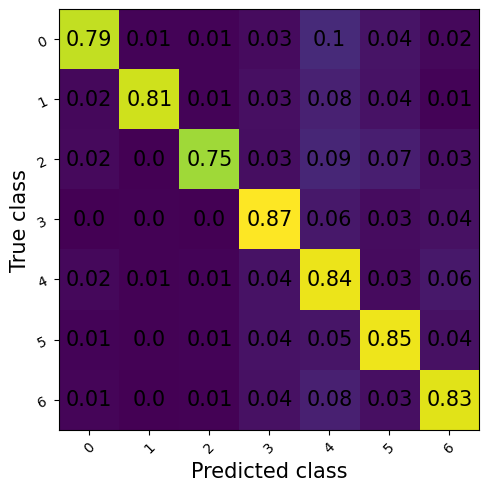

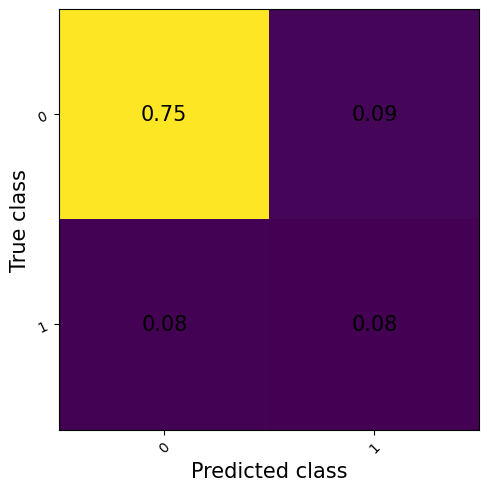

In [20]:
_ = val_report.get_confusion_matrix('electra_extraction_51', plot = True)
_ = val_report.get_confusion_matrix('electra_extraction_51_t', plot = True)

In [105]:
#get trigger effects of best models
table = {}
for name in bests:
    table.update(test_report.get_trigger_effect(name))
values = [np.array([np.array([v for v in scores.values()]).flatten() for scores in model.values()]).flatten().tolist() for model in table.values()]
columns = next(iter(table.values())).keys()
sub_columns = next(iter(next(iter(table.values())).values())).keys()
indexes = table.keys()
report_df = pd.DataFrame(values, columns = pd.MultiIndex.from_product([tuple(columns), tuple(sub_columns)]), index=indexes)
report_df

emotion_accuracy             support       
                                 correct_t     bad_t correct_t  bad_t
bert_extraction_666               0.675214  0.725000     205.0  355.0
bert_extraction_freeze_77         0.643411  0.636364     224.0  336.0
bert_concat_51                    0.619048  0.744304      54.0  506.0
bert_concat_nopooling_666         0.833333  0.753117      52.0  508.0
electra_extraction_51             0.666667  0.715170     201.0  359.0

In [56]:
with pd.option_context('display.max_rows', None):
    print(test_report.get_utterance_ranking('electra_extraction_51'))
#make a graph?

                accuracy  dialogue_len
episode                               
utterance_1408  0.000000           4.0
utterance_1445  0.000000           4.0
utterance_2214  0.000000           3.0
utterance_1515  0.166667           6.0
utterance_3881  0.250000          12.0
utterance_640   0.250000          12.0
utterance_317   0.250000           4.0
utterance_956   0.250000           4.0
utterance_202   0.333333           6.0
utterance_1129  0.333333           3.0
utterance_1631  0.333333           3.0
utterance_1696  0.333333           3.0
utterance_2255  0.333333           3.0
utterance_2300  0.333333           3.0
utterance_2433  0.333333           3.0
utterance_2680  0.333333           3.0
utterance_2888  0.333333           3.0
utterance_2961  0.333333           3.0
utterance_3296  0.333333           3.0
utterance_3312  0.333333           3.0
utterance_488   0.333333           3.0
utterance_1522  0.375000           8.0
utterance_1589  0.375000           8.0
utterance_3880  0.375000 

<Axes: title={'center': 'Dialogue emotion accuracy by length'}, xlabel='dialogue_len'>

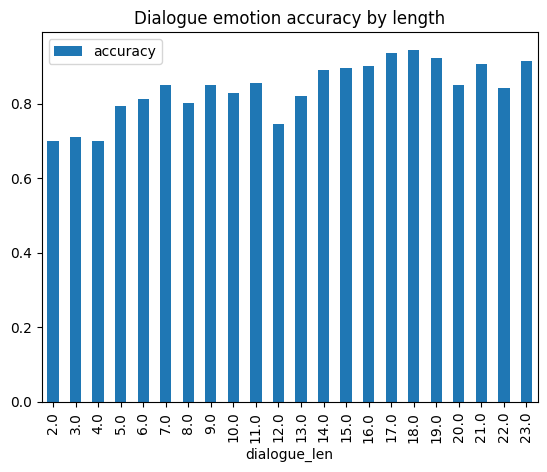

In [64]:
#accuracy plot by len
test_report.get_utterance_ranking('electra_extraction_51').groupby(['dialogue_len']).mean().plot(kind='bar', title='Dialogue emotion accuracy by length')

In [77]:
table = test_report.get_emotions_table()
table_df = pd.DataFrame(table.values())
table_df = table_df.map(lambda x: x.item() if type(x) == torch.Tensor else x)
table_df = table_df[table_df['name'].isin(bests)]
table_df

,name,sadness_acc,fear_acc,disgust_acc,surprise_acc,neutral_acc,anger_acc,joy_acc,sadness_f1,fear_f1,disgust_f1,surprise_f1,neutral_f1,anger_f1,joy_f1
3,bert_extraction_666,0.750000,0.764228,0.747748,0.854167,0.826872,0.810345,0.813996,0.763441,0.773663,0.775701,0.789981,0.856648,0.794926,0.792825
9,bert_extraction_freeze_77,0.633803,0.788618,0.621622,0.825000,0.753342,0.706897,0.732965,0.634921,0.795082,0.660287,0.747875,0.793942,0.679089,0.711986
12,bert_concat_51,0.820423,0.829268,0.747748,0.875000,0.882353,0.836207,0.856354,0.802065,0.864407,0.772093,0.873181,0.892495,0.831726,0.832587
18,bert_concat_nopooling_666,0.823944,0.837398,0.801802,0.868750,0.887701,0.866379,0.861878,0.823944,0.887931,0.805430,0.861570,0.896994,0.852598,0.844004
22,electra_extraction_51,0.785211,0.821138,0.729730,0.875000,0.842246,0.840517,0.832413,0.779720,0.845188,0.778846,0.830861,0.869565,0.810811,0.812950


In [24]:
worsts_dialogues = test_report.get_utterance_ranking('electra_extraction_51').iloc[:5].index.values
labels = test_report.emotion_labels

table = test_report.df
table = table[table['episode'].isin(worsts_dialogues)]
table['preds'] = table['electra_extraction_51'].apply(lambda x: labels[x.argmax(-1).item()])
table['emotions'] = table['emotions_id'].apply(lambda x: labels[int(x)])
table['preds_t'] = table['electra_extraction_51_t'].apply(lambda x: (x>0.5).int().item())
with pd.option_context('display.max_columns', None): 
    print(table[['episode','utterance_index','preds', 'emotions', 'preds_t', 'triggers',]])
with pd.option_context('display.max_colwidth', None): 
    print(table.groupby('episode').first()[['dialogue_index','utterance_index','dialogue_text']])


             episode  utterance_index preds emotions  preds_t  triggers
0     utterance_3881                0     4        4        0         0
1     utterance_3881                1     3        4        0         0
2     utterance_3881                2     6        6        0         0
3     utterance_3881                3     4        2        0         0
4     utterance_3881                4     5        2        0         0
5     utterance_3881                5     4        0        0         0
6     utterance_3881                6     5        4        0         0
7     utterance_3881                7     4        6        0         0
8     utterance_3881                8     4        4        0         0
9     utterance_3881                9     3        2        0         0
10    utterance_3881               10     5        4        1         0
11    utterance_3881               11     5        6        1         1
182   utterance_1445                0     4        5        0   

C:\Users\cacio\AppData\Local\Temp\ipykernel_11084\476799291.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  table['preds'] = table['electra_extraction_51'].apply(lambda x: labels[x.argmax(-1).item()])
C:\Users\cacio\AppData\Local\Temp\ipykernel_11084\476799291.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  table['emotions'] = table['emotions_id'].apply(lambda x: labels[int(x)])
C:\Users\cacio\AppData\Local\Temp\ipykernel_11084\476799291.py:8: SettingWithCopyWarning: 
A value is trying to be set on 

In [38]:
best_dialogues = test_report.get_utterance_ranking('electra_extraction_51').sort_values(['accuracy','dialogue_len'], ascending=[False, False]).iloc[26:28].index.values
#best_dialogues = ['utterance_3913, utterance_3202']
labels = test_report.emotion_labels

table = test_report.df
table = table[table['episode'].isin(best_dialogues)]
table['preds'] = table['electra_extraction_51'].apply(lambda x: labels[x.argmax(-1).item()])
table['emotions'] = table['emotions_id'].apply(lambda x: labels[int(x)])
table['preds_t'] = table['electra_extraction_51_t'].apply(lambda x: (x>0.5).int().item())
with pd.option_context('display.max_columns', None, 'display.max_rows', None): 
    print(table[['episode','utterance_index','preds', 'emotions', 'preds_t', 'triggers',]])
with pd.option_context('display.max_colwidth', None, 'display.max_rows', None): 
    print(table.groupby('episode').first()[['dialogue_index','utterance_index','dialogue_text']])
print(table.groupby('episode').first()[['dialogue_text']].values)

# GOOD CORRECT DIALOGUES
#utterance 3913
#utterance 3202 not so much
#utterance 815

             episode  utterance_index preds emotions  preds_t  triggers
2559   utterance_815                0     6        6        0         0
2560   utterance_815                1     4        4        0         0
2561   utterance_815                2     4        4        0         0
2562   utterance_815                3     6        6        0         0
2563   utterance_815                4     0        0        0         0
2564   utterance_815                5     6        6        0         0
2565   utterance_815                6     4        4        0         0
2566   utterance_815                7     4        4        0         0
2567   utterance_815                8     6        6        1         0
2568   utterance_815                9     4        4        1         0
2569   utterance_815               10     6        6        1         1
2972  utterance_1528                0     2        2        0         0
2973  utterance_1528                1     3        3        0   

C:\Users\cacio\AppData\Local\Temp\ipykernel_11084\1728414201.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  table['preds'] = table['electra_extraction_51'].apply(lambda x: labels[x.argmax(-1).item()])
C:\Users\cacio\AppData\Local\Temp\ipykernel_11084\1728414201.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  table['emotions'] = table['emotions_id'].apply(lambda x: labels[int(x)])
C:\Users\cacio\AppData\Local\Temp\ipykernel_11084\1728414201.py:9: SettingWithCopyWarning: 
A value is trying to be set 

In [164]:
len(test_data_tokenized)

3501

In [103]:
# ALL IS WORKING FINE
# report.get_trigger_effect('baseline_666')
# report.get_confusion_matrix('baseline_666', plot = False)
# report.get_confusion_matrix('baseline_666_t', plot = False)
# report.get_precision_recall('baseline_666', plot = False)
# report.get_precision_recall('baseline_666_t', plot = False)
# report.get_emotions_table()
# report.get_misclassified('baseline_666')
# report.get_misclassified('baseline_666_t')
# report.get_performance_table()
# report.get_trigger_table()
# report.get_utterance_ranking('baseline_666')
# report.get_utterance_ranking('baseline_666_t')


In [39]:
#Some functions return dict or list of dict. check usage in error_analysis.ipynb If you want dataframes visualization, you can do something like this
table = report.get_emotions_table()
print(table)
table_df = pd.DataFrame(table.values())
table_df = table_df.map(lambda x: x.item() if type(x) == torch.Tensor else x)
table_df

{'baseline_666': {'name': 'baseline_666', '0_acc': tensor(0.), '1_acc': tensor(1.), '2_acc': tensor(0.), '3_acc': tensor(0.), '4_acc': tensor(0.), '5_acc': tensor(0.), '6_acc': tensor(0.), '0_f1': tensor(0.), '1_f1': tensor(0.6422), '2_f1': tensor(0.), '3_f1': tensor(0.), '4_f1': tensor(0.), '5_f1': tensor(0.), '6_f1': tensor(0.)}, 'support': {'1_acc': 149, '1_f1': 149, '4_acc': 45, '4_f1': 45, '3_acc': 36, '3_f1': 36, '6_acc': 34, '6_f1': 34, '2_acc': 29, '2_f1': 29, '5_acc': 11, '5_f1': 11, '0_acc': 11, '0_f1': 11, 'name': 'support'}}


,name,0_acc,1_acc,2_acc,3_acc,4_acc,5_acc,6_acc,0_f1,1_f1,2_f1,3_f1,4_f1,5_f1,6_f1
0,baseline_666,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.642241,0.0,0.0,0.0,0.0,0.0
1,support,11.0,149.0,29.0,36.0,45.0,11.0,34.0,11.0,149.000000,29.0,36.0,45.0,11.0,34.0


In [58]:
#TABLE FOR TRIGGER ANALYSIS
table = report.get_trigger_table()
values = [np.array([np.array([v for v in scores.values()]).flatten() for scores in model.values()]).flatten().tolist() for model in table.values()]
columns = next(iter(table.values())).keys()
sub_columns = next(iter(next(iter(table.values())).values())).keys()
indexes = table.keys()
report_df = pd.DataFrame(values, columns = pd.MultiIndex.from_product([tuple(columns), tuple(sub_columns)]), index=indexes)
report_df

emotion_accuracy         support      
                    correct_t bad_t correct_t bad_t
baseline_666              0.0  0.42       0.0  60.0